# Lecture 3: Oceanic lithosphere

This notebook uses the data in the `data` folder and model outputs to make figures for the lecture. 

## General instructions

This is a [Jupyter notebook](https://jupyter.org/) running in [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/). The notebook is a programming environment that mixes code (the parts with `[1]: ` or similar next to them) and formatted text/images/equations with [Markdown](https://www.markdownguide.org/basic-syntax) (like this part right here).

Quick start guide:

* **Edit** any cell (blocks of code or text) by double clicking on it.
* **Execute** a code or Markdown cell by typing `Shift + Enter` after selecting it.
* The current active cell is the one with a **blue bar next to it**.
* You can run cells **in any order** as long as the code sequence makes sense (it's best to go top-to-bottom, though).
* To copy any file to the current directory, drag and drop it to the file browser on the left side.
* Notebook files have the extension `.ipynb`.

## Import things

As always, start by importing the packages that we need.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import xarray as xr
import pandas as pd
import cmocean
import cartopy.crs as ccrs
import verde as vd

## Global heat flow

Plot the global heat flow grid from [Lucazeau (2019)](https://doi.org/10.1029/2019GC008389).

In [2]:
global_heat = pd.read_csv("../../data/HFgrid14.csv", sep=";")
global_heat

,longiyude,latitude,HF_pred,sHF_pred,Hf_obs
0,-179.75,89.75,121.0,19.9,NaN
1,-179.25,89.75,80.2,32.8,NaN
2,-178.75,89.75,81.1,44.5,NaN
3,-178.25,89.75,81.0,44.6,NaN
4,-177.75,89.75,109.1,19.0,NaN
...,...,...,...,...,...
259195,177.75,-89.75,75.4,36.5,NaN
259196,178.25,-89.75,75.4,36.5,NaN
259197,178.75,-89.75,75.4,36.5,NaN
259198,179.25,-89.75,75.2,36.8,NaN


Make a grid by linear interpolation so we can easily plot it.

In [3]:
interpolator = vd.ScipyGridder("linear").fit((global_heat.longiyude, global_heat.latitude), global_heat.HF_pred)
grid = interpolator.grid(region=(-180, 180, -90, 90), spacing=0.5, dims=("latitude", "longitude"), data_names=["heat_flow"])
grid.heat_flow.attrs["long_name"] = "Heat flow"
grid.heat_flow.attrs["units"] = "mW/m²"
grid

<xarray.Dataset>
Dimensions:    (latitude: 361, longitude: 721)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.5 -179.0 ... 179.0 179.5 180.0
  * latitude   (latitude) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
Data variables:
    heat_flow  (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    metadata:  Generated by ScipyGridder(extra_args=None, method='linear')

And finally make a map of the grid. Crop the colorbar to the same range as the paper.

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


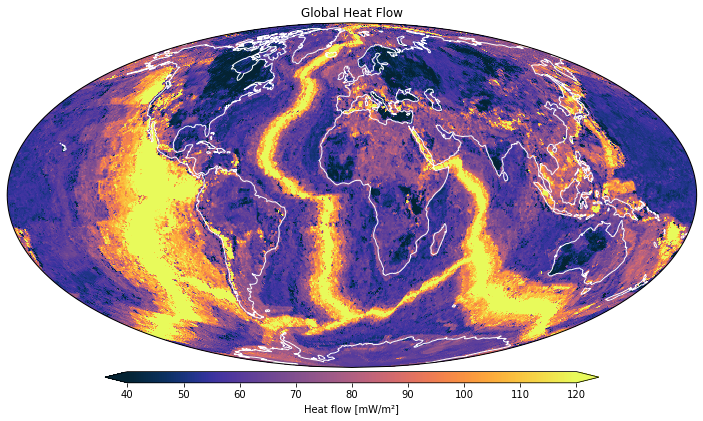

In [4]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
grid.heat_flow.plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cmap=cmocean.cm.thermal, 
    vmin=40, 
    vmax=120,
    cbar_kwargs=dict(orientation="horizontal", aspect=40, pad=0.01, shrink=0.7),
)
ax.set_title("Global Heat Flow")
ax.coastlines(color="w")
plt.subplots_adjust(top=0.95, bottom=0, right=0.99, left=0.01, hspace=0, wspace=0)
plt.savefig("global-heat-flow.png", dpi=200)
plt.show()

## Half space model

Implement and plot the half space cooling model.